Model Training Code

In [1]:
#import all of the dependencies

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve, 
    auc, 
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import joblib
import json
from pathlib import Path

In [3]:
train = pd.read_csv('../data/processed/train.csv')
val = pd.read_csv('../data/processed/val.csv')
test = pd.read_csv('../data/processed/test.csv')

# Separate features and labels
X_train = train.drop('Class', axis=1)
y_train = train['Class']

X_val = val.drop('Class', axis=1)
y_val = val['Class']

X_test = test.drop('Class', axis=1)
y_test = test['Class']


In [9]:
# Verify feature order matches preprocessing metadata
import json
with open('../data/processed/preprocessing_metadata.json', 'r') as f:
    preprocess_meta = json.load(f)

expected_features = preprocess_meta['features']['model_features']
actual_features = list(X_train.columns)

assert expected_features == actual_features, f"Feature mismatch!\nExpected: {expected_features}\nActual: {actual_features}"
print("Feature order verified against preprocessing metadata")

Feature order verified against preprocessing metadata


In [10]:
model = LogisticRegression(
    class_weight='balanced',  # Automatically weights classes inversely proportional to frequency
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


Validation Metrics:
  PR-AUC: 0.6737
  ROC-AUC: 0.9692


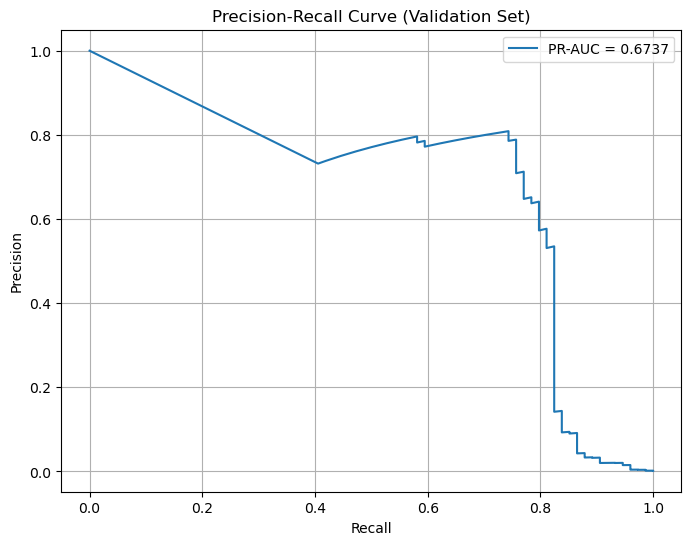

In [11]:
#evaluate on validation set
y_val_proba = model.predict_proba(X_val)[:, 1]

# PR-AUC
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
pr_auc = auc(recall, precision)

# ROC-AUC for comparison
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"\nValidation Metrics:")
print(f"  PR-AUC: {pr_auc:.4f}")
print(f"  ROC-AUC: {roc_auc:.4f}")

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.savefig('../data/processed/pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
#find optimal threshold

y_val_pred = model.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)  # Same as recall

print(f"\nAt default threshold (0.5):")
print(f"  FPR: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"  Recall: {tpr:.4f} ({tpr*100:.2f}%)")

# Find threshold that gives FPR at 0.5%
target_fpr = 0.005
best_threshold = 0.5
best_recall = 0

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred_thresh = (y_val_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_thresh).ravel()
    
    current_fpr = fp / (fp + tn)
    current_recall = tp / (tp + fn)
    
    if current_fpr <= target_fpr and current_recall > best_recall:
        best_threshold = threshold
        best_recall = current_recall

# Evaluate at best threshold
y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_best).ravel()

print(f"\nAt optimized threshold ({best_threshold:.3f}):")
print(f"  FPR: {fp / (fp + tn):.4f}")
print(f"  Recall: {tp / (tp + fn):.4f}")
print(f"  Precision: {tp / (tp + fp):.4f}")


At default threshold (0.5):
  FPR: 0.0228 (2.28%)
  Recall: 0.8649 (86.49%)

At optimized threshold (0.860):
  FPR: 0.0050
  Recall: 0.8243
  Precision: 0.2226


In [13]:
#final evaluation on test set

y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Metrics
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc_test = auc(recall_test, precision_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
fpr_test = fp / (fp + tn)
recall_test_at_threshold = tp / (tp + fn)
precision_test_at_threshold = tp / (tp + fp)

print(f"\nTest Set Performance:")
print(f"  PR-AUC: {pr_auc_test:.4f}")
print(f"  FPR: {fpr_test:.4f} ({fpr_test*100:.2f}%)")
print(f"  Recall: {recall_test_at_threshold:.4f} ({recall_test_at_threshold*100:.2f}%)")
print(f"  Precision: {precision_test_at_threshold:.4f}")


Test Set Performance:
  PR-AUC: 0.8026
  FPR: 0.0050 (0.50%)
  Recall: 0.8514 (85.14%)
  Precision: 0.2291


In [14]:
#convert this into a pytorch model

class FraudModel(nn.Module):
    #Simple linear model that replicates sklearn LogisticRegression
    def __init__(self, weights, bias):
        super().__init__()
        self.linear = nn.Linear(weights.shape[1], 1)
        
        # Copy sklearn weights
        self.linear.weight.data = torch.tensor(weights, dtype=torch.float32)
        self.linear.bias.data = torch.tensor(bias, dtype=torch.float32)
    
    def forward(self, x):
        logits = self.linear(x)
        proba = torch.sigmoid(logits)
        return proba.squeeze()

# Extract sklearn weights
weights = model.coef_  # Shape: (1, n_features)
bias = model.intercept_  # Shape: (1,)

# Create PyTorch model
pytorch_model = FraudModel(weights, bias)
pytorch_model.eval()

# Verify equivalence
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
pytorch_proba = pytorch_model(X_val_tensor).detach().numpy()
sklearn_proba = model.predict_proba(X_val.values)[:, 1]

max_diff = np.abs(pytorch_proba - sklearn_proba).max()
print(f"\nPyTorch vs Sklearn max difference: {max_diff:.6f}")
assert max_diff < 1e-5, "PyTorch model doesn't match sklearn!"


PyTorch vs Sklearn max difference: 0.000001


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [17]:
#export to torchscript
Path('../services/infer').mkdir(parents=True, exist_ok=True)

# Trace the model (converts to TorchScript)
example_input = torch.randn(1, X_train.shape[1])
traced_model = torch.jit.trace(pytorch_model, example_input)

# Save
model_path = '../services/infer/model.pt'
traced_model.save(model_path)

# Test loading
loaded_model = torch.jit.load(model_path)
loaded_proba = loaded_model(X_val_tensor).detach().numpy()
assert np.allclose(loaded_proba, pytorch_proba), "Loaded model doesn't match!"


In [18]:
#save model metadata

feature_cols = list(X_train.columns)

model_metadata = {
    'model_type': 'LogisticRegression',
    'framework': 'sklearn → PyTorch → TorchScript',
    'training_date': pd.Timestamp.now().isoformat(),
    
    'features': {
        'names': feature_cols,
        'count': len(feature_cols),
    },
    
    'performance': {
        'pr_auc_val': float(pr_auc),
        'pr_auc_test': float(pr_auc_test),
        'roc_auc_val': float(roc_auc),
        'optimal_threshold': float(best_threshold),
        'fpr_at_threshold': float(fpr_test),
        'recall_at_threshold': float(recall_test_at_threshold),
        'precision_at_threshold': float(precision_test_at_threshold),
    },
    
    'thresholds': {
        'allow': 0.3,      # risk < 0.3
        'step_up': 0.7,    # 0.3 ≤ risk < 0.7
        'block': 0.7,      # risk ≥ 0.7
    },
    
    'training_data': {
        'n_train': len(X_train),
        'n_val': len(X_val),
        'n_test': len(X_test),
        'fraud_rate': float(y_train.mean()),
    }
}

metadata_path = '../services/infer/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)